# Analyzing k-means and Finding the Right Number of Clusters

When using k-means clustering, you need to decide how many groups (or clusters) your data should be divided into. This number is called k, and choosing it carefully is very important:

If k is too small, you might combine things that don’t really belong together, missing important patterns.
If k is too large, the groups will be so tiny that they lose meaning and don’t help us understand the data.
To find the best k, we can use two common methods:

The Inertia Elbow Method: This looks at how "compact" the clusters are as we try different k values, helping us find a point where adding more clusters doesn't improve much.

The Silhouette Score: This measures how well each data point fits into its cluster. A higher score means better clusters.

---
## 1.&nbsp; Import libraries and files 💾

In [ ]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import plotly.graph_objects as go

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Get the spreadsheet ID and name
sheet_id = "1CSkJ7w90A+++++++++++++++++++++++++++++++++++E70pKE"
sheet_name = "2087670046"

# Construct the URL to the CSV export of the spreadsheet
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Read the CSV data into a Pandas DataFrame
# Set the index column to `artist` and drop the `name` column
songs_df = pd.read_csv(url, index_col="Unnamed: 0").drop(columns=["name", "id", "type", "key","mode", "html", "duration_ms","time_signature", "artist"])

# Display the first few rows to confirm the data is loaded correctly
print(songs_df.tail())



      danceability  energy  loudness  speechiness acousticness  \
5230         202.0   694.0   -23.390        473.0          917   
5231         188.0   101.0   -21.873        442.0          855   
5232         596.0    93.0   -42.959        434.0          951   
5233         133.0   208.0   -29.443        419.0          883   
5234         354.0   487.0   -24.568        323.0          783   

     instrumentalness  liveness  valence   tempo  
5230              715     832.0    655.0  87.906  
5231              426     694.0    355.0  83.134  
5232              969     772.0    344.0  71.573  
5233              505     111.0    591.0  67.109  
5234              484     284.0    253.0  64.120  


---
## 2.&nbsp; Scale the data 📐
In this notebook, we are only using the MinMaxScaler to keep the code simple and focus on the inertia and silhouette scores. However, we encourage you to experiment with other scalers, as they can have a impact.

In [ ]:

# Handle NaNs and scale the features
songs_numeric_df = songs_df.select_dtypes(include=['float64', 'int64']).fillna(0)  # Filter numeric data and fill NaNs
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features_df = scaler.fit_transform(songs_numeric_df)

# Display the scaled DataFrame
print(scaled_features_df.head())

   danceability    energy  loudness  speechiness  liveness   valence     tempo
0      0.661972  0.259259  0.529571     0.705706  0.975976  0.306613  0.515800
1      0.746479  0.399399  0.529861     0.346346  0.107107  0.694389  0.584322
2      0.856137  0.000731  0.530800     0.347347  0.124124  0.906814  0.437862
3      0.709256  0.502503  0.526650     0.471471  0.386386  0.525050  0.499098
4      0.654930  0.119119  0.525656     0.038038  0.104104  0.402806  0.565171


---
## 3.&nbsp; Estimate the number of clusters (k) 🔢

### 3.1.&nbsp; Inertia and the elbow method

In clustering, inertia is a measure of how well data points fit into their assigned clusters. Lower inertia indicates a better fit. However, minimising inertia alone can lead to meaningless clusters, with each data point in its own cluster.

The elbow method is a visual aid for identifying the optimal number of clusters. It plots inertia values for different cluster numbers, revealing an "elbow" where the inertia reduction begins to plateau. This plateau indicates that reducing inertia further has little impact on cluster quality.

To find the inertia score for our clusters, we can use the [KMeans attribute ](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)`.inertia_`.

We will cluster our food preferences data multiple times, starting with 1 cluster and increasing the number of clusters by 1 each time until we reach `max_k`. We will store the inertia score for each clustering in a list.

Once we've calculated the inertia scores for all values of k, we'll plot them on a line chart. We'll then look for the "elbow" in the line chart. The elbow is the point where the inertia score starts to plateau, indicating that adding more clusters is not significantly improving the quality of the clustering.

In [ ]:
from sklearn.cluster import KMeans

# Decide on a random_state to use for reproducibility
seed = 123

# Set the maximum number of clusters to try
max_k = 12

# Create an empty list to store the inertia scores
inertia_list = []

# Iterate over the range of cluster numbers
for k in range(1, max_k + 1):
    # Create a KMeans object with k clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(scaled_features_df)

    # Append the inertia score (sum of squared distances) to the list
    inertia_list.append(kmeans.inertia_)

# Display the inertia scores
print("Inertia Scores:", inertia_list)


Inertia Scores: [2139.5395674787287, 1754.0553736948061, 1498.8767247111723, 1246.0201228731466, 1148.9907303053758, 1050.2737076453266, 978.1022693277696, 908.3216165560739, 868.9635469196828, 821.0570599184365, 800.4045350837981, 772.4179761235396]


#Visualize the Elbow Method

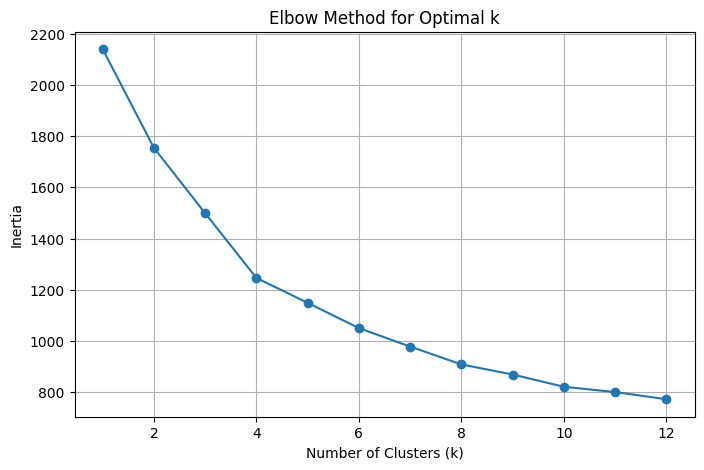

In [ ]:
import matplotlib.pyplot as plt

# Plot the inertia scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), inertia_list, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()


Where the elbow lies is not always clear - it's up to you to decide, you're the data scientist. If there are multiple points where you believe the elbow could be, use your knowledge of the business case to inform your decision. How many data points do you have? How many would be in a cluster if you chose this number of clusters? What is the point of making these clusters? Is there a logical number of clusters, where if you make more clusters they just become too small for your business case?
> The elbow method is a heuristic, meaning that it is not guaranteed to find the optimal number of clusters in all cases.

### 3.2.&nbsp; The silhouette score
The silhouette score is another metric for evaluating the quality of clustering results. It measures how well each data point is assigned to its cluster, taking into account the distance to other clusters. The silhouette score ranges from -1 to 1, with higher scores indicating better clustering.

The silhouette score can be used to identify the optimal number of clusters by clustering the data with different numbers of clusters and selecting the number of clusters that has the highest the silhouette score.

To calculate the silhouette score we'll use the [SKLearn function ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)`silhouette_score`.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set the maximum number of clusters to try
max_k = 12

# Create an empty list to store the silhouette scores
sil_scores = []

# Loop through cluster numbers from 2 to max_k (silhouette requires at least 2 clusters)
for k in range(2, max_k):
    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(scaled_features_df)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score for the current clustering
    score = silhouette_score(scaled_features_df, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

# Display the silhouette scores
print("Silhouette Scores:", sil_scores)


Silhouette Scores: [0.20789537758865362, 0.17906356423036773, 0.20297597140126922, 0.20816169732160186, 0.20746141892367895, 0.20903835183528705, 0.20744598916252813, 0.19739768757061774, 0.1970439083931987, 0.18739905579963206]


# Visualize Silhouette Scores

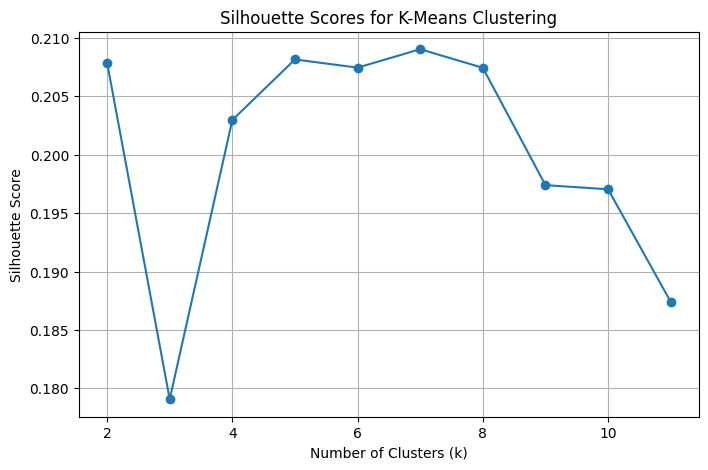

In [ ]:
import matplotlib.pyplot as plt

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_k), sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for K-Means Clustering")
plt.grid()
plt.show()


To determine the optimal number of clusters, we can look for the highest silhouette score. This score measures how well each point is assigned to its cluster, with higher scores indicating better clustering.

However, the highest silhouette score may not always be the best choice. For example, if the score is very high for a large number of clusters, it may be a sign that the clusters are too finely grained and that we are overfitting the data.

In addition, we should consider our business objectives and the data we are using. For example, if we are clustering customers based on their purchase history, we may want to choose a smaller number of clusters so that we can easily identify different customer segments.

Therefore, it's important to use the silhouette score in conjunction with other methods, such as the elbow method, and to consider our business objectives and the data we are using when choosing the optimal number of clusters.
> You can also experiment with different values for random_state. It's possible that you got a "bad seed" and this is leading to misleading results. Make sure to use the same random_state for both the inertia and silhouette methods so that you are comparing the same clusters.

---
## 4.&nbsp; Explore the cluster means 🗺️

#### 4.1.&nbsp; Column averages
By grouping the clusters and looking at the average score for each column, you can learn more about the different groups of students and their food preferences. For example, you might find that one group of students prefers healthy foods like broccoli and peas, while another group prefers more processed foods like hamburgers. You might also find that some groups of students have a more diverse range of food preferences than others.

In [ ]:
from sklearn.cluster import KMeans

# Initialise the model
my_kmeans = KMeans(n_clusters= 4,# Number of clusters
                   random_state=123)

# Fit the model to the data
my_kmeans.fit(scaled_features_df)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to the scaled DataFrame
scaled_features_df["cluster"] = clusters

# Display the first few rows with the cluster labels
print(scaled_features_df.head(4))


   danceability    energy  loudness  speechiness  liveness   valence  \
0      0.661972  0.259259  0.529571     0.705706  0.975976  0.306613   
1      0.746479  0.399399  0.529861     0.346346  0.107107  0.694389   
2      0.856137  0.000731  0.530800     0.347347  0.124124  0.906814   
3      0.709256  0.502503  0.526650     0.471471  0.386386  0.525050   

      tempo  cluster  
0  0.515800        3  
1  0.584322        1  
2  0.437862        2  
3  0.499098        1  


In [ ]:
scaled_features_df.groupby(by="cluster").mean()

,danceability,energy,loudness,speechiness,liveness,valence,tempo
cluster,,,,,,,
0,0.303198,0.848930,0.532304,0.397786,0.215714,0.272103,0.569315
1,0.592081,0.751037,0.532592,0.397977,0.455033,0.629544,0.559710
2,0.442749,0.200137,0.528432,0.390311,0.809754,0.399075,0.527023
3,0.444543,0.190599,0.528970,0.372990,0.153287,0.391206,0.534810


#### 4.2.&nbsp; Radar chart
Having calculated the average score for each food by cluster, we now have a matrix that we can analyse. However, as data scientists with coding skills, we can visualise this information to gain a clearer understanding of why certain people are clustered together and why others aren't.

Visualising the data can help us to identify patterns and trends that would be difficult to see in a matrix. For example, we might be able to see that certain foods are consistently grouped together, while others are more spread out. This could suggest that there are different subgroups of students with different dietary preferences.

We can also use visualisation to identify outliers. For example, we might find a few students who have very different food preferences than the rest of the group. This could be due to a variety of factors, such as cultural background, medical conditions, or personal preferences.

In [ ]:
import plotly.graph_objects as go

# Create an empty list to store the Scatterpolar object of each cluster
scatter_objects = []

# State the label for each arm of the chart
categories = scaled_features_df.columns[:-1]  # Exclude 'cluster' column

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(scaled_features_df['cluster'].unique()):
    # Calculate mean values for all features in the current cluster using list comprehension
    cluster_means = [scaled_features_df.loc[scaled_features_df["cluster"] == cluster, col].mean() for col in categories]

    # Create a Scatterpolar object for the cluster
    cluster_scatter = go.Scatterpolar(
        r=cluster_means,  # set the radial coordinates
        theta=categories,  # the names of the columns
        fill='toself',  # fills in the space with colour
        name=f'Cluster {cluster}'  # adds the name of the cluster
    )

    # Add the Scatterpolar object to the list
    scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
    title_text='Radar Chart of Mean Features by Cluster',
    height=600,
    width=800,
    polar=dict(
        radialaxis=dict(
            visible=True,  # visibility of the numbers on the arm
            range=[0, 1]  # scale of the plot
        )
    ),
    showlegend=True
)

# Show the plot
fig.show()


In [ ]:
from sklearn.cluster import KMeans

# Re-run clustering with different initialization
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(scaled_features_df)

# Assign the clusters to the dataframe
songs_df['cluster'] = clusters




In [ ]:
import pandas as pd

# Reload the dataset (adjust path and file format)
original_df = pd.read_csv(url, index_col="Unnamed: 0")  # Do NOT drop "artist" and "name"

# Reattach artist and songname columns to songs_df
songs_df["artist"] = original_df["artist"]
songs_df["songname"] = original_df["name"]

# Add the cluster labels
songs_df["cluster"] = clusters

# Group by clusters
for cluster in sorted(songs_df["cluster"].unique()):
    print(f"Cluster {cluster}:")
    print(songs_df[songs_df["cluster"] == cluster][["artist", "songname"]].tail(3))


Cluster 0:
              artist                                           songname
5231  Tristan Murail  Winter Fragments pour ensemble instrumental, s...
5233  Antonín Dvořák  Serenade For Strings In E, Op.22, B. 52: 1. Mo...
5234   Maurice Ravel  Ravel: Boléro, M. 81                          ...
Cluster 1:
                        artist  \
5228               Béla Bartók   
5230  Pyotr Ilyich Tchaikovsky   
5232         Arnold Schoenberg   

                                               songname  
5228  Music for Strings, Percussion and Celesta, BB ...  
5230  1812 Festival Overture, Op. 49: 1812 Overture,...  
5232  Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...  
Cluster 2:
                     artist                                           songname
5165       Sergei Prokofiev  Symphony No.1 in D, Op.25 "Classical Symphony"...
5171  Einojuhani Rautavaara  Cantus arcticus, Op. 61, "Concerto for Birds a...
5224       Allan Pettersson                                     Symphony 

In [ ]:
# Loop through all expected clusters (assuming 4 clusters)
for cluster in range(4):  # Adjust the range if the number of clusters is different
    print(f"Cluster {cluster}:")
    cluster_songs = songs_df[songs_df["cluster"] == cluster]
    if cluster_songs.empty:
        print("No songs in this cluster.")
    else:
        print(cluster_songs[["artist", "songname"]].head().to_string(index=False))
    print("\n")


Cluster 0:
                       artist                               songname
            Sílvia Pérez Cruz                                Não Sei
                    Stan Getz                              Corcovado
                  Tribalistas Já Sei Namorar - 2004 Digital Remaster
Pete Krebs & The Kung Pao Chi                           Bossa Dorado
                 Luisa Sobral                                   Inês


Cluster 1:
              artist            songname
Antônio Carlos Jobim    Saudade De Bahia
         Chico César       Mulher Eu Sei
   Sílvia Pérez Cruz O Meu Amor É Glòria
   Paula Morelenbaum   Brigas Nunca Mais
       Bossacucanova            Previsao


Cluster 2:
          artist                                                                                                                                                                        songname
    Gilberto Gil                                                                                              